Reference：
https://www.kaggle.com/competitions/ml2021spring-hw1

# **1. 讀入封包 Import Some Packages**


In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import pandas as pd
import os
import csv
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler  ## MinMaxScaler for normalize



# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


# Feature selection
from sklearn.model_selection import KFold
#Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler # SelectKBest 挑選出K個分數最高的特徵
from sklearn.feature_selection import SelectKBest # 這是一稱為aNOVA的統計檢驗方法
from sklearn.feature_selection import f_classif



## version2 for better performance #How to choose random seed
# myseed = 2020815  # set a random seed for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(myseed)
# torch.manual_seed(myseed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Importing files**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ml2021spring-hw1/covid.train.csv', index_col='id') #caution! specific for each folder name
train.head()

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [ ]:
train.describe()

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,...,16.578290,36.074941,10.257474,2.385735,18.067635,13.058828,19.243283,64.834307,44.568440,16.431280
std,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,...,5.651583,6.655166,4.686263,1.053147,2.250081,1.628589,2.708339,6.220087,5.232030,7.619354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.200532,30.606711,6.532543,1.714080,16.420485,11.914167,17.322912,59.782876,40.549987,10.327314
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.227010,36.041389,9.700368,2.199521,17.684197,12.948749,18.760267,65.932259,43.997637,15.646480
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,21.207162,41.508520,13.602566,2.730469,19.503419,14.214320,20.713638,69.719651,48.118283,22.535165
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,28.488220,50.606465,24.496711,8.162275,28.574091,18.715944,28.366270,77.701014,58.433600,40.959495


In [ ]:
train[train.columns[40:]].describe()

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.991587,1.016136,29.442496,24.323054,89.682322,8.894498,31.703307,55.277153,16.694342,36.283177,...,16.578290,36.074941,10.257474,2.385735,18.067635,13.058828,19.243283,64.834307,44.568440,16.431280
std,0.420296,0.423629,9.093738,8.446750,5.380027,3.404027,4.928902,4.525917,5.668479,6.675206,...,5.651583,6.655166,4.686263,1.053147,2.250081,1.628589,2.708339,6.220087,5.232030,7.619354
min,0.126321,0.132470,9.961640,6.857181,70.950912,1.252983,18.311941,43.220187,3.637414,21.485815,...,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708
25%,0.673929,0.697515,23.203165,18.539153,86.309537,6.177754,28.247865,51.547206,13.311050,30.740931,...,13.200532,30.606711,6.532543,1.714080,16.420485,11.914167,17.322912,59.782876,40.549987,10.327314
50%,0.912747,0.940295,28.955738,23.819761,90.819435,8.288288,32.143140,55.257262,16.371699,36.267966,...,16.227010,36.041389,9.700368,2.199521,17.684197,12.948749,18.760267,65.932259,43.997637,15.646480
75%,1.266849,1.302040,36.109114,30.238061,93.937119,11.582209,35.387315,58.866130,21.396971,41.659971,...,21.207162,41.508520,13.602566,2.730469,19.503419,14.214320,20.713638,69.719651,48.118283,22.535165
max,2.597732,2.625885,56.832289,51.550450,98.087160,18.552325,42.359074,65.673889,28.488220,50.606465,...,28.488220,50.606465,24.496711,8.162275,28.574091,18.715944,28.366270,77.701014,58.433600,40.959495


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2700 entries, 0 to 2699
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AL                      2700 non-null   float64
 1   AK                      2700 non-null   float64
 2   AZ                      2700 non-null   float64
 3   AR                      2700 non-null   float64
 4   CA                      2700 non-null   float64
 5   CO                      2700 non-null   float64
 6   CT                      2700 non-null   float64
 7   FL                      2700 non-null   float64
 8   GA                      2700 non-null   float64
 9   ID                      2700 non-null   float64
 10  IL                      2700 non-null   float64
 11  IN                      2700 non-null   float64
 12  IA                      2700 non-null   float64
 13  KS                      2700 non-null   float64
 14  KY                      2700 non-null   

In [ ]:
test =pd.read_csv('/content/drive/MyDrive/ml2021spring-hw1/covid.test.csv', index_col='id') # define the first col as id
test.head()

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,52.071090,8.624001,29.374792,5.391413,2.754804,19.695098,13.685645,24.747837,66.194950,44.873473
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.742461,21.720187,41.375784,9.450179,3.150088,22.075715,17.302077,23.559622,57.015009,38.372829
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.109045,20.123959,40.072556,8.781522,2.888209,23.920870,18.342506,24.993341,55.291498,38.907257
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.442267,16.083529,36.977612,5.199286,2.575347,21.073800,12.087171,18.608723,67.036197,43.142779
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.588783,19.503010,42.631236,11.549771,8.530551,15.896575,11.781634,15.065228,61.196518,43.574676


In [ ]:
# Print the first 40 states
# The first 40 columns are one-hot-encoded states.
train[train.columns[:40]]

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,OR,PA,RI,SC,TX,UT,VA,WA,WV,WI
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The dataset is split into three parts. Day one data, day two data, and day three data.

*   4 column(s) - COVID-like illness
*   8 column(s) - behavior indicators
*   5 column(s) - mental health indicators
*   1 column(s) - tested positive cases (target prediction)


In [ ]:
day_one = train.columns[40:58]
day_two = train.columns[58:76]
day_three = train.columns[76:94]

In [ ]:
train[day_one].head()

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive
id,,,,,,,,,,,,,,,,,,
0,0.814610,0.771356,25.648907,21.242063,84.644672,13.462475,36.519841,63.139094,23.835119,44.726055,16.946929,1.716262,15.494193,12.043275,17.000647,53.439316,43.279629,19.586492
1,0.838995,0.807767,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838
2,0.897802,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
3,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
4,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116842,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656


In [ ]:
train[day_two].head()

,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1
id,,,,,,,,,,,,,,,,,,
0,0.838995,0.807767,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838
1,0.897802,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
2,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
3,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116842,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
4,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607


In [ ]:
train[day_three].head()

,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
id,,,,,,,,,,,,,,,,,,
0,0.897802,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116842,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,0.883833,0.893020,26.480624,21.003982,84.049437,12.224644,35.380198,60.664482,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


# **Feature selection**

In [ ]:
## ver01 sklearn - preprocessing #

# normalize 正規化與標準化資料_Min-max scaling # 正規化：　　for feature selection

x = train[train.columns[1:93]]
y = train[train.columns[93]]

## method 01 - 套公式
x = (x - x.min()) / (x.max() - x.min())
# x.head()

# method 02 - sklearn API 套件 : MinMaxScaler >>> OK
min_max = MinMaxScaler()
train_set_min_maxed_b = pd.DataFrame(min_max.fit_transform(train),columns=train.keys())
train_set_min_maxed_b.head()

#SelectKBest將通過該p值對特徵進行排名（越低越好）並且僅保留好的K個表徵。
#從將f_classif作為SelectKBest的參數，也就是p值的統計檢驗方法，我們手動輸入一個K值為5，做為將保留最好的K個表徵
bestfeatures = SelectKBest(score_func=f_regression, k=5)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 15 best features

                 Specs          Score
74   tested_positive.1  148069.658278
56     tested_positive   69603.872591
41        hh_cmnty_cli    9235.492094
59      hh_cmnty_cli.1    9209.019558
77      hh_cmnty_cli.2    9097.375172
42      nohh_cmnty_cli    8395.421300
60    nohh_cmnty_cli.1    8343.255927
78    nohh_cmnty_cli.2    8208.176435
39                 cli    6388.906849
57               cli.1    6374.548000
75               cli.2    6250.008702
40                 ili    5998.922880
58               ili.1    5937.588576
76               ili.2    5796.947672
91  worried_finances.2     833.613191


In [ ]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=True):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
            # feats = list(range(1, 40)) + [57, 75]
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # feats = list(range(1, 41)) + [57, 75]
            feats = [74, 56, 41, 59, 77, 42, 60, 78, 39, 57, 75, 40, 58, 76] #上面挑选的最优特征
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            # 在确定参数后，使用所有数据进行训练，即训练集=验证集
            if mode == 'train':
                #indices = [i for i in range(len(data)) if i % 10 != 0]
                indices = [i for i in range(len(data))]
            elif mode == 'dev':
                #indices = [i for i in range(len(data)) if i % 10 == 0]
                indices = [i for i in range(len(data))]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])


        # Normalize features (you may remove this part to see what will happen) #正規化: for test & dev
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))


    #### implements the Z-score normalization (standardization) formula for the selected features in the dataset. ###
    #### The Z-score normalization formula is given by: Z = (X - μ) / σ  ###

    #### Z is the standardized value (Z-score) of a data point.
    #### X is the original value of the data point.
    #### μ is the 'mean of the selected feature values' along the dataset axis (mean along the column).
    #### σ is the 'standard deviation' of the selected feature values along the dataset axis (standard deviation along the column).


    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)



# **DataLoader**

In [ ]:
def prep_dataloader(path, mode, batch_size, n_jobs= 0, target_only = False):
  '''Generates a dataset, then is put into a datalaoder'''
  #創建自定義的數據集對象 dataset = XXXDataset
  dataset = COVID19Dataset(path, mode=mode, target_only = target_only) #construct dataset
  #創建Dataloader
  dataloader = DataLoader(dataset, batch_size, shuffle = (mode == 'train'), drop_last = False, num_workers = n_jobs, pin_memory = True)
  #Construct dataloader
  return dataloader

# **Deep Neural Network**
NeuralNet is an `nn.Module` designed for regression. The DNN consists of 2 fully-connected layers with ReLU activation. This module also included a function `cal_loss` for calculating loss.

In [ ]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?

        ######ver01: strong_baseline_: train 結果0.94
        # self.net = nn.Sequential(
        #     nn.Linear(input_dim, 128),
        #     nn.BatchNorm1d(128),#使用BN，加速模型训练
        #     nn.Dropout(p=0.2),#使用Dropout，减小过拟合，注意不能在BN之前
        #     nn.LeakyReLU(),#更换激活函数
        #     nn.Linear(128, 1)
        # )

        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,1),
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        #self.criterion = nn.SmoothL1Loss(size_average=True)

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        regularization_loss = 0
        for param in model.parameters():
        # TODO: you may implement L1/L2 regularization here
        # 使用L2正则项
            # regularization_loss += torch.sum(abs(param))
            regularization_loss += torch.sum(param ** 2)
        return self.criterion(pred, target) + 0.00075 * regularization_loss

# **Train/ Dev/ Test**

**Training**

In [ ]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [ ]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [ ]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**
`config` contains hyper-parameters for training and the path to save your model.

In [ ]:
device = get_device()
os.makedirs('models', exist_ok=True)
target_only = True                   # 使用前面设置的特征

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # 因为有early_stop，所以大一点没有影响
    'batch_size': 200,               # 微调batchsize
    'optimizer': 'Adam',              # 使用Adam优化器
    'optim_hparas': {                # 完全使用默认参数
        #'lr': 0.0001,
        #'momentum': 0.9,
        #'weight_decay': 5e-4,
    },
    'early_stop': 500,               # 由于最后训练使用了所有数据，大一点影响不大
    'save_path': 'models/model.pth'
}

# **Load data and model**

In [ ]:
# Assuming the path to the dataset CSV file is stored in a variable named 'path'
path = '/content/drive/MyDrive/ml2021spring-hw1/covid.train.csv'

tr_set = prep_dataloader(path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (2700 samples found, each dim = 14)


In [ ]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [ ]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 25.3861)
Saving model (epoch =    2, loss = 13.1754)
Saving model (epoch =    3, loss = 6.1173)
Saving model (epoch =    4, loss = 3.7929)
Saving model (epoch =    5, loss = 2.8698)
Saving model (epoch =    6, loss = 2.0828)
Saving model (epoch =    7, loss = 1.5760)
Saving model (epoch =    9, loss = 1.4018)
Saving model (epoch =   10, loss = 1.3788)
Saving model (epoch =   11, loss = 1.3702)
Saving model (epoch =   15, loss = 1.3206)
Saving model (epoch =   16, loss = 1.3076)
Saving model (epoch =   17, loss = 1.2959)
Saving model (epoch =   18, loss = 1.2852)
Saving model (epoch =   19, loss = 1.2765)
Saving model (epoch =   21, loss = 1.2730)
Saving model (epoch =   25, loss = 1.2672)
Saving model (epoch =   26, loss = 1.2105)
Saving model (epoch =   27, loss = 1.2009)
Saving model (epoch =   30, loss = 1.1844)
Saving model (epoch =   33, loss = 1.1503)
Saving model (epoch =   36, loss = 1.1325)
Saving model (epoch =   37, loss = 1.1251)
Saving mo

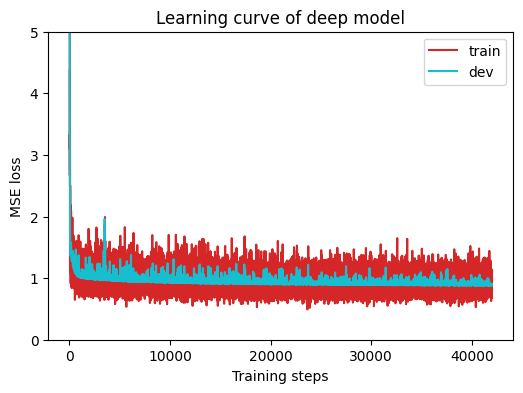

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

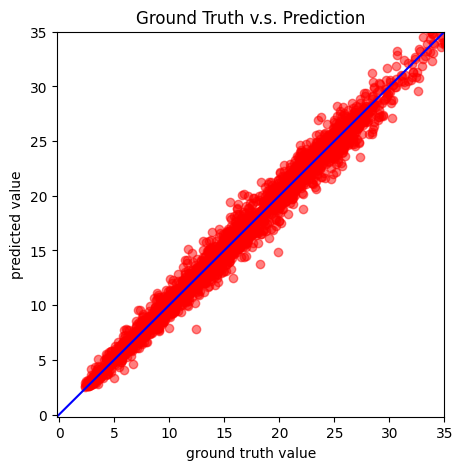

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv.`

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
